In [78]:
import Modules.SQcircuit_extensions as sq_ext
import Modules.figures as figs
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

from importlib import reload
reload(sq_ext)

<module 'Modules.SQcircuit_extensions' from 'C:\\Users\\gabri\\PycharmProjects\\tunable-capacitive-coupling-flux-qubits\\Modules\\SQcircuit_extensions.py'>

In [79]:
C, CJ, Csh, Lq, Lr, Δ, EJ = sq_ext.get_experimental_parameters('qubit_1', return_effective=False)
C_F_eff, C_R_eff = sq_ext.C_CJ_Csh_to_CF_CR_eff(C, CJ, Csh)
L_F_eff, L_R_eff, L_C_eff = sq_ext.Lq_Lr_to_LF_LR_LC_eff(Lq, Lr, Δ)

In [80]:
C, CJ, Csh, Lq, Lr, Δ, EJ = sq_ext.get_experimental_parameters('qubit_1', return_effective=False)
C_F_eff, C_R_eff = sq_ext.C_CJ_Csh_to_CF_CR_eff(C, CJ, Csh)
L_F_eff, L_R_eff, L_C_eff = sq_ext.Lq_Lr_to_LF_LR_LC_eff(Lq, Lr, Δ)
# EJ*=2
L_R_eff *=2.8
L_C_eff*=10

In [81]:
nmax_f = 25
nmax_r = 15
φ_ext_vales_plot = [0.50001, 0.51, 0.55]

φ_ext_values =np.concatenate(([0.5],  0.5  + np.geomspace(1e-5, 0.2, 200)))
φ_ext_indices = [np.where(np.abs(φ_ext_values-φ_ext) == np.abs(φ_ext_values-φ_ext).min())[0][0] for φ_ext in  φ_ext_vales_plot]

In [82]:
fluxonium = sq_ext.sq_fluxonium(EJ=EJ, C_F_eff=C_F_eff, L_F_eff =L_F_eff, Δ=Δ, nmax_f=nmax_f)
resonator = sq_ext.sq_resonator(L_R_eff=L_R_eff, C_R_eff=C_R_eff, Δ=Δ, nmax_r=nmax_r )
circuits = [fluxonium, resonator]
H0_list = [circuit.hamiltonian() for circuit in circuits]
H0 = sq_ext.H0_from_list(H0_list)
# H0 = sq_ext.hamiltonian_qubit(fluxonium,resonator,L_C_eff)
len_H = H0.shape[0]
n_eig = len_H
E0, ψ0 = sq_ext.diag(H0, n_eig, remove_ground=True, fix_phase=True, solver='numpy')

In [83]:
E = np.zeros([len(φ_ext_values), n_eig])
ψ = np.zeros([len(φ_ext_values), len_H, n_eig], dtype='complex')
H = np.zeros([len(φ_ext_values), len_H, len_H], dtype='complex')

loop = fluxonium.loops[0]
for i, φ_ext  in enumerate(φ_ext_values):
    loop.set_flux(φ_ext)
    H[i] = sq_ext.hamiltonian_qubit(fluxonium, resonator, L_C_eff) 
    E[i] , ψ[i] = sq_ext.diag(H[i], n_eig, remove_ground=True, fix_phase=True, solver='numpy')

In [84]:
overlap = np.zeros([len(φ_ext_values), n_eig, n_eig], dtype='complex')
H_in_ψ0 = np.zeros([len(φ_ext_values), n_eig, n_eig], dtype='complex') 
H_in_ψ0_2 = np.zeros([len(φ_ext_values), n_eig, n_eig], dtype='complex') 
for i in range(len(φ_ext_values)) :
    overlap[i] = ψ0.conj().T  @ ψ[i]
    H_in_ψ0[i] = overlap[i] @ np.diag(E[i]) @ overlap[i].conj().T
    # H_in_ψ0_2[i] = ψ0.conj().T @ H[i].__array__() @ ψ0 / 2/ np.pi / 1e9

### Fluxonium eigensates expressed in the basis at frustration

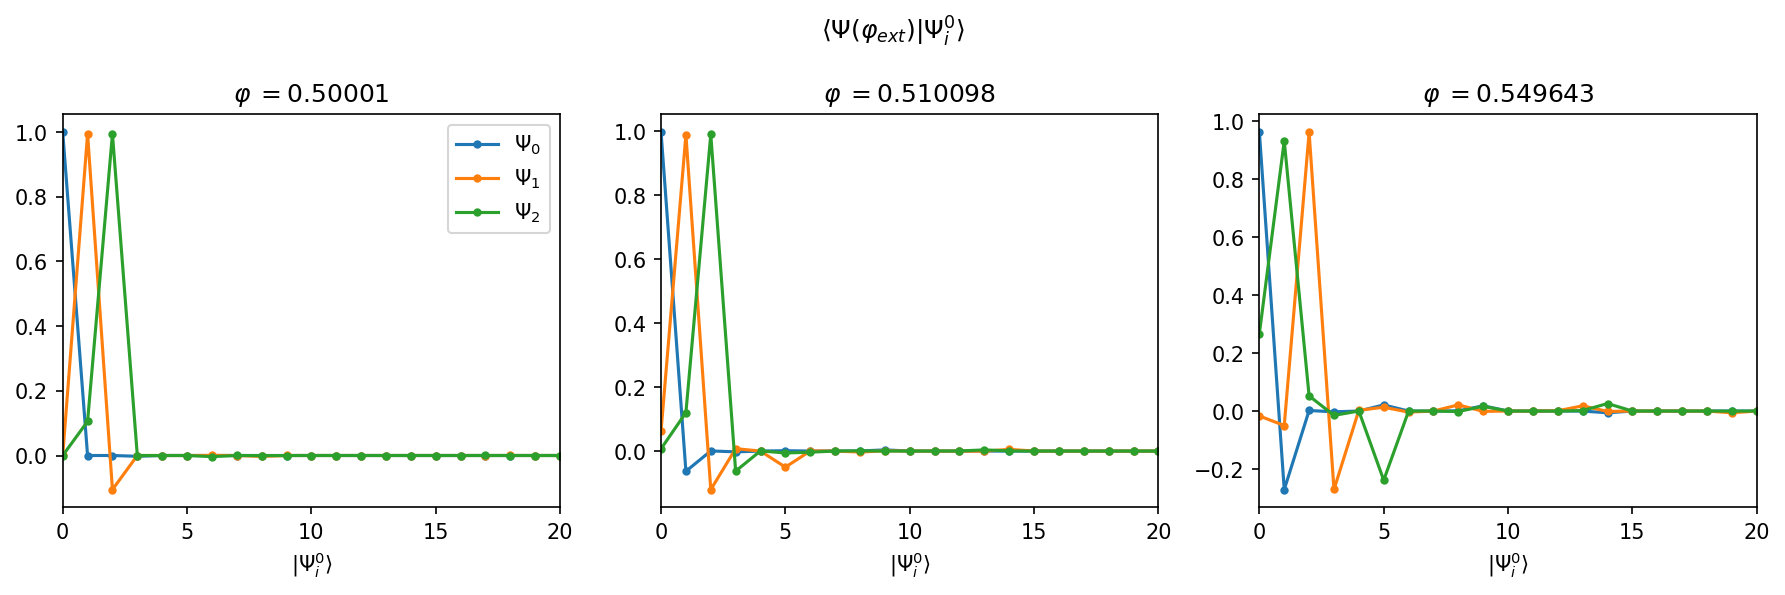

In [85]:
fig, axs = plt.subplots(ncols=3, figsize = [12, 4], dpi=150)
for ax, φ_ext_index in zip(axs, φ_ext_indices) :
    for k in range(3):
        ax.plot(overlap[φ_ext_index,:,k],'.-', label=rf'$\Psi_{k}$')
    ax.set_title(fr'$\varphi_ = {np.round(φ_ext_values[φ_ext_index],6)}$')
    ax.set_xlim([0,20])
    ax.set_xlabel(r'$|\Psi_i^0\rangle$')
axs[0].legend()
fig.suptitle(r'$\langle\Psi(\varphi_{ext})|\Psi_i^0\rangle$')
fig.tight_layout()

### Ground state at $\varphi_{ext}\ne0.5$ expressed with the basis at frustration

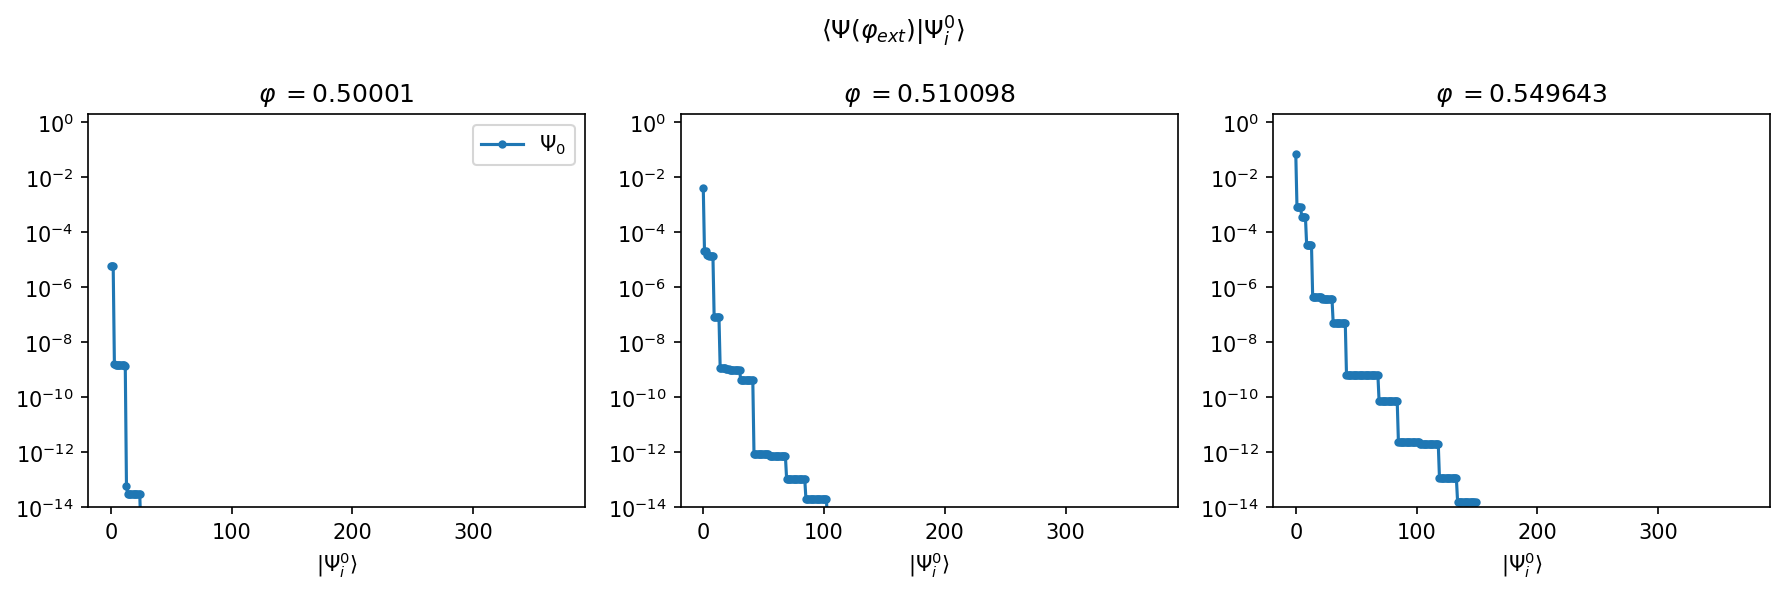

In [86]:
fig, axs = plt.subplots(ncols=3, figsize = [12, 4], dpi=150)
for ax, φ_ext_index in zip(axs, φ_ext_indices) :
    for k in range(1):
        ax.plot(1-np.cumsum(np.abs(overlap[φ_ext_index,:,k])**2),'.-', label=rf'$\Psi_{k}$')
    ax.set_title(fr'$\varphi_ = {np.round(φ_ext_values[φ_ext_index],6)}$')
    # ax.set_xlim([0,20])
    ax.set_ylim([1e-14,2])
    ax.set_yscale('log')
    ax.set_xlabel(r'$|\Psi_i^0\rangle$')
axs[0].legend()
fig.suptitle(r'$\langle\Psi(\varphi_{ext})|\Psi_i^0\rangle$')
fig.tight_layout()

### Fluxonium hamiltonian expressed in the basis at frustration

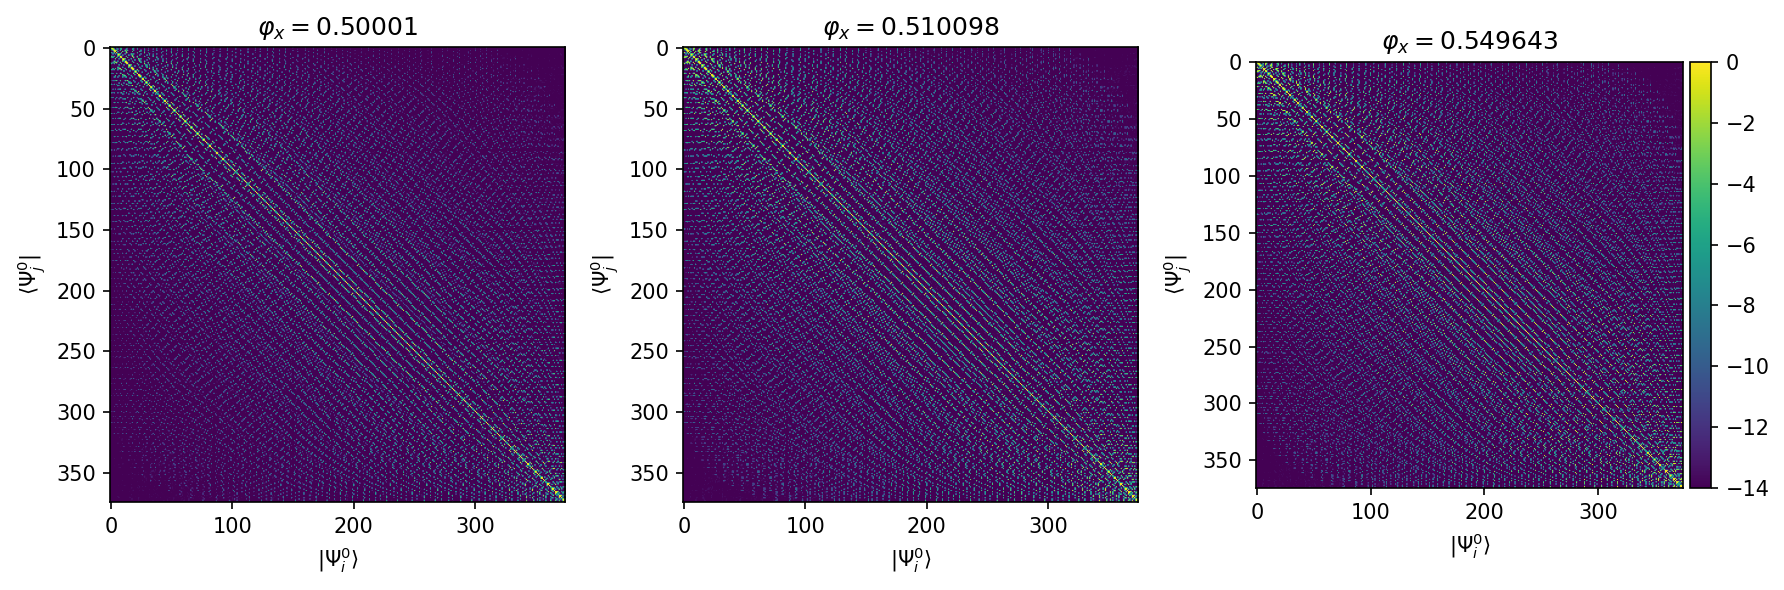

In [87]:
fig, axs = plt.subplots(ncols=3, figsize = [12, 4], dpi=150)
ticks=np.arange(-10,0)
for ax, φ_ext_index in zip(axs, φ_ext_indices) :
    c = ax.imshow(np.log10(np.abs(H_in_ψ0[φ_ext_index])),vmin=-14, vmax=0)
    ax.set_title(fr'$\varphi_x = {np.round(φ_ext_values[φ_ext_index],6)}$')
    ax.set_xlabel(r'$|\Psi_i^0\rangle$')
    ax.set_ylabel(r'$\langle\Psi_j^0|$')
    
figs.colorbar(c)  
fig.tight_layout()

### Matrix elements of the ground state

C:\Users\gabri\AppData\Local\Temp\ipykernel_7636\1219516848.py:4: RuntimeWarning: divide by zero encountered in divide
  ax.plot(np.abs(H_in_ψ0[φ_ext_index,:,0] / np.diag(H_in_ψ0[φ_ext_index]-H_in_ψ0[φ_ext_index,0,0]) )[1:],'.-')
C:\Users\gabri\AppData\Local\Temp\ipykernel_7636\1219516848.py:4: RuntimeWarning: invalid value encountered in divide
  ax.plot(np.abs(H_in_ψ0[φ_ext_index,:,0] / np.diag(H_in_ψ0[φ_ext_index]-H_in_ψ0[φ_ext_index,0,0]) )[1:],'.-')


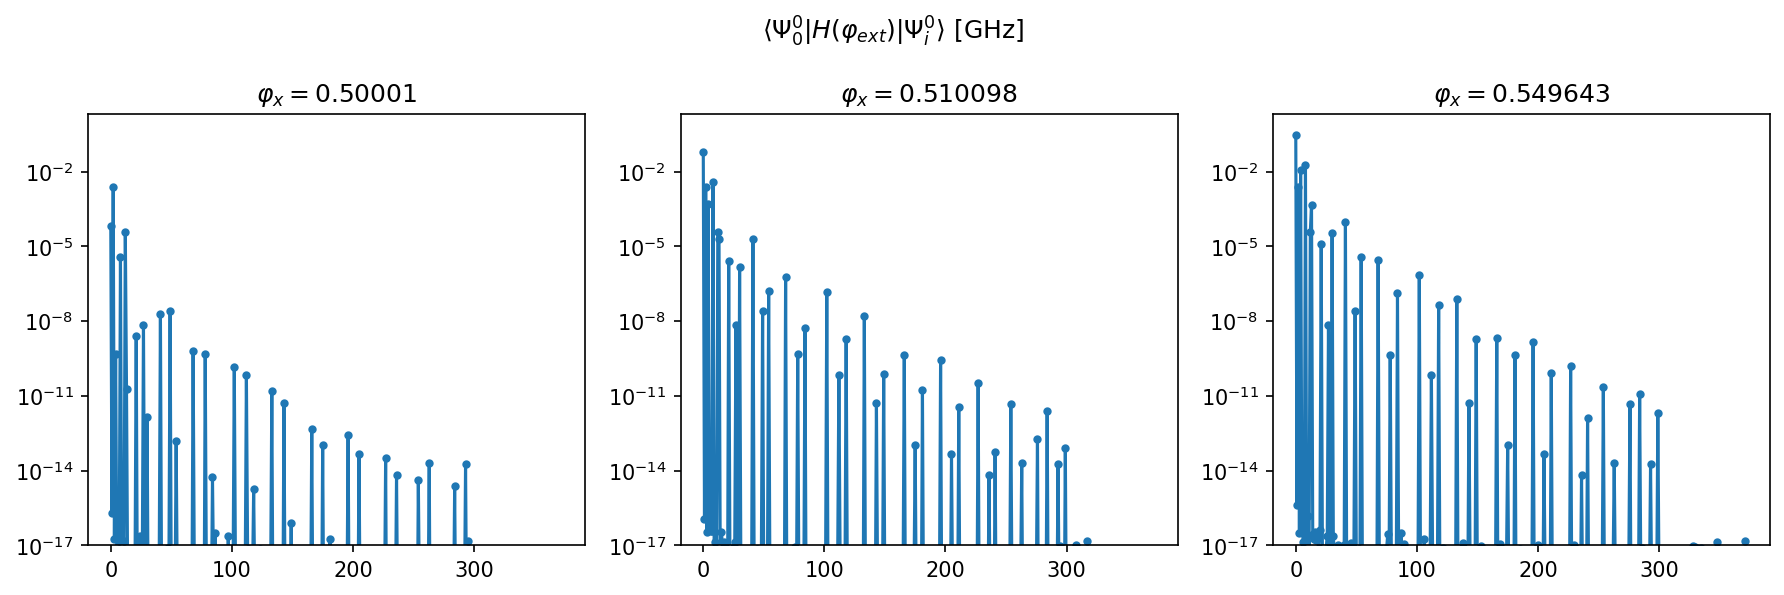

In [88]:
fig, axs = plt.subplots(ncols=3, figsize = [12, 4], dpi=150)

for ax, φ_ext_index in zip(axs, φ_ext_indices) :
    ax.plot(np.abs(H_in_ψ0[φ_ext_index,:,0] / np.diag(H_in_ψ0[φ_ext_index]-H_in_ψ0[φ_ext_index,0,0]) )[1:],'.-')
    # ax.plot(np.abs(H_in_ψ0[φ_ext_index,:,0]) ,'.-')
    ax.set_yscale('log')
    ax.set_ylim([1e-17,2])
    ax.set_title(fr'$\varphi_x = {np.round(φ_ext_values[φ_ext_index],6)}$')
    
fig.suptitle(r'$\langle\Psi_0^0|H(\varphi_{ext})|\Psi_i^0\rangle$ [GHz]')    
fig.tight_layout()

## Progressively cropping the basis 

In [89]:
n_basis = np.arange(2, 20, 1)

E_vs_φ_ext_n   = []
error_vs_φ_ext_n = []

for i in range(len(φ_ext_values)) :
    E_vs_n      = []
    error_vs_n  = [] 
    for n in n_basis:
        E_in_ψ0 = sq_ext.diag(H_in_ψ0[i,:n,:n],n,solver='numpy', out=None,remove_ground=True)[0]
        E_vs_n.append(E_in_ψ0)
        error_vs_n.append(np.abs(E_in_ψ0[1:]-E[i,1:n]))
    error_vs_φ_ext_n.append(error_vs_n) 
    E_vs_φ_ext_n.append(E_vs_n) 
    

### Error in the spectrum of the fluxonium in the basis at frustration (with progressively cropped basis)

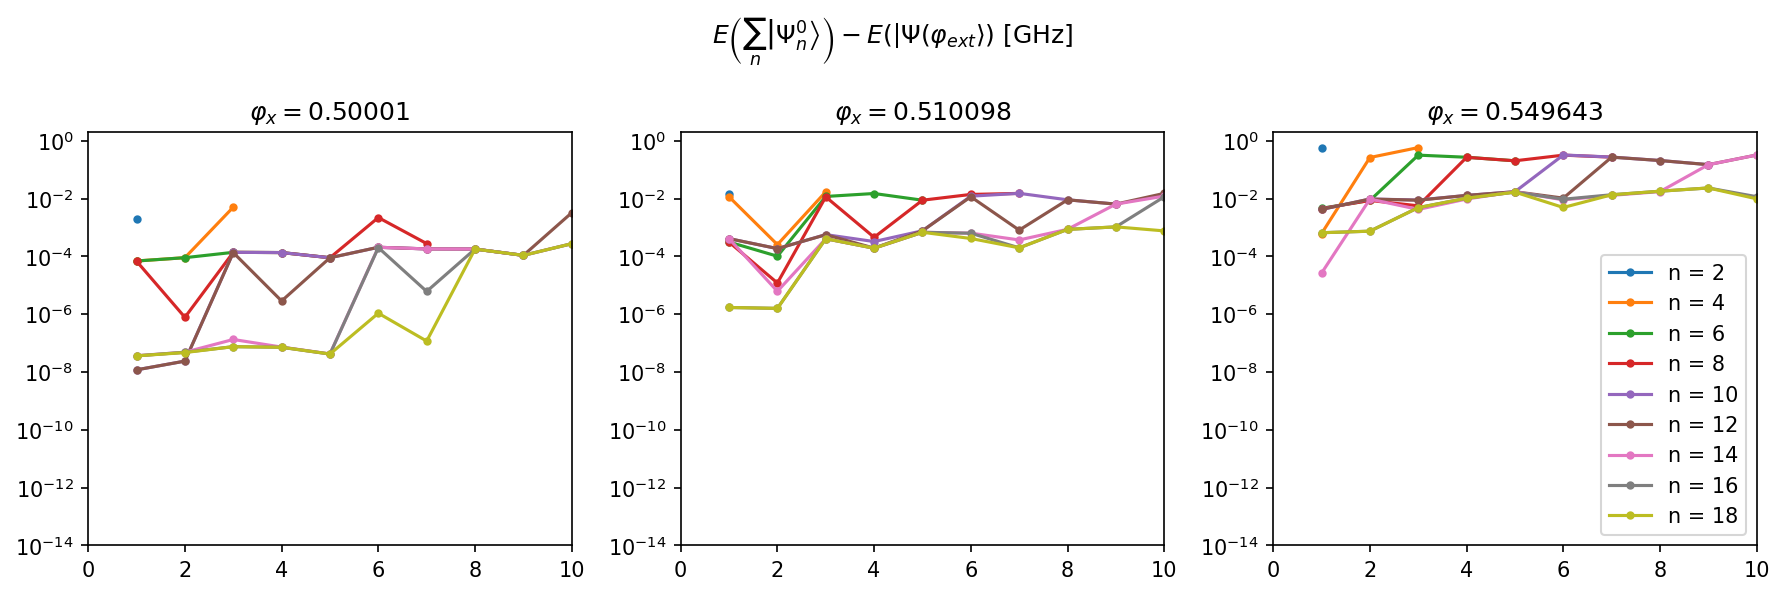

In [90]:
fig, axs = plt.subplots(ncols=3, figsize = [12, 4], dpi=150)

for ax, φ_ext_index in zip(axs, φ_ext_indices) :
    error_vs_n = error_vs_φ_ext_n[φ_ext_index]
    for n, error in zip(n_basis[::2], error_vs_n[::2]):
        ax.plot(np.arange(1,n), error,'.-', label=f'n = {n}')
        
        ax.set_yscale('log')
        ax.set_ylim([1e-14,2])
        ax.set_xlim([0,10])
        ax.set_title(fr'$\varphi_x = {np.round(φ_ext_values[φ_ext_index],6)}$')
fig.suptitle(r'$E\left(\sum_n\left|\Psi_n^0\right\rangle\right) - E\left(\left|\Psi(\varphi_{ext}\right\rangle\right) $ [GHz]')   
axs[-1].legend()
fig.tight_layout()

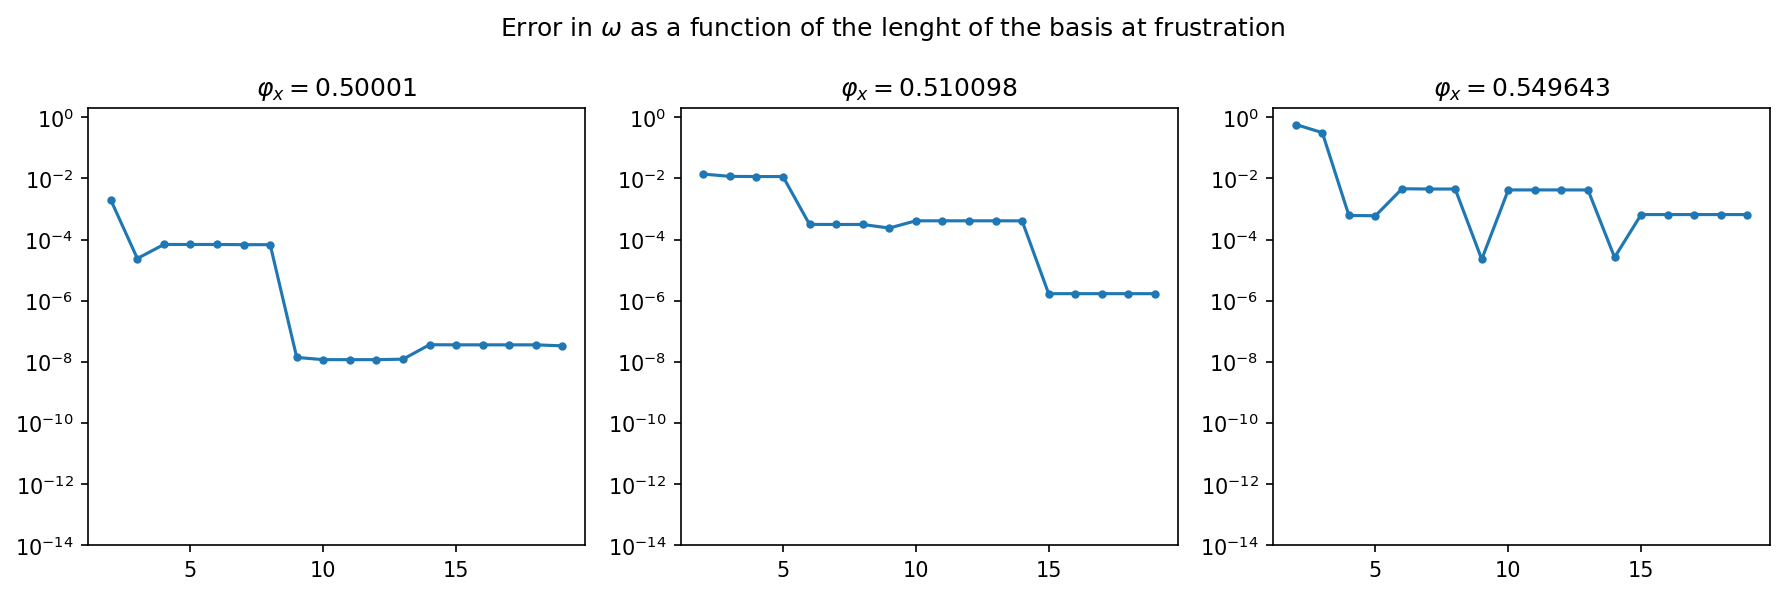

In [91]:
fig, axs = plt.subplots(ncols=3, figsize = [12, 4], dpi=150)

for  ax, φ_ext_index in zip(axs, φ_ext_indices):
    error_vs_n = error_vs_φ_ext_n[φ_ext_index]
    error_in_ω = [error_n[0] for error_n in error_vs_n]
    ax.plot(n_basis, error_in_ω, '.-')
    ax.set_title(fr'$\varphi_x = {np.round(φ_ext_values[φ_ext_index],6)}$')
    ax.set_yscale('log')
    ax.set_ylim([1e-14,2])

fig.suptitle('Error in $\omega$ as a function of the lenght of the basis at frustration')
fig.tight_layout()

### Spectrum vs $\varphi_{ext}$

In [92]:
E_vs_n_φ_ext =[ ]
for n in range(len(n_basis)):
    E_vs_φ_ext = []
    for i in range(len(φ_ext_values)):
        E_vs_φ_ext.append(E_vs_φ_ext_n[i][n])
    E_vs_n_φ_ext.append(E_vs_φ_ext)

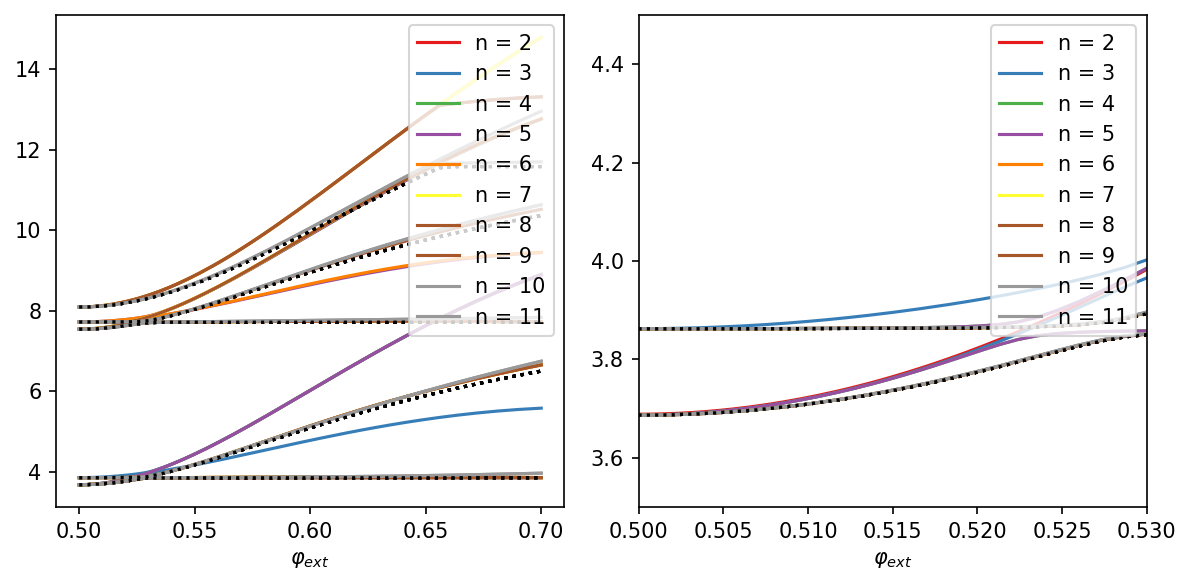

In [93]:
fig, axs = plt.subplots(ncols=2,figsize=[8,4], dpi=150)
colors = figs.generate_colors_from_colormap(10, colormap_name='Set1')
for ax in axs:
    for n_index, (n, E_vs_φ_ext) in enumerate(zip((n_basis[:10]), E_vs_n_φ_ext[:10])):
        E_vs_φ_ext = np.array(E_vs_φ_ext)
        for k in range(1,n):
            if k ==6:
                break
            if k==1:
                label = f'n = {n}'
            else:
                label = None
            ax.plot(φ_ext_values,  np.array(E_vs_φ_ext)[:,k] , color=colors[n_index], label=label )
            ax.plot(φ_ext_values,  E[:,k] ,':k')
    ax.legend()
    ax.set_xlabel(r'$\varphi_{ext}$')
    
axs[1].set_xlim([0.5,0.53])
axs[1].set_ylim([3.5,4.5])
# ax.set_yscale('log')
fig.tight_layout()

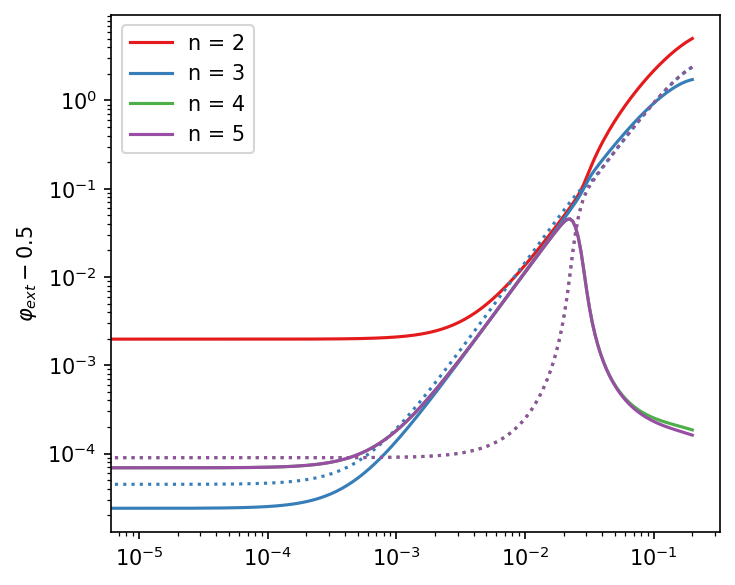

In [102]:
fig, ax = plt.subplots(figsize=[5,4], dpi=150)
colors = figs.generate_colors_from_colormap(10, colormap_name='Set1')
linestyles = [_,'-',':']
for n_index, (n, E_vs_φ_ext) in enumerate(zip((n_basis[:4]), E_vs_n_φ_ext[:4])):
    E_vs_φ_ext = np.array(E_vs_φ_ext)
    for k in range(1,n):
        if k ==3:
            break
        if k==1:
            label = f'n = {n}'
        else:
            label = None
        ax.plot(φ_ext_values-0.5,  np.abs(np.array(E_vs_φ_ext)[:,k]-E[:,k]) , color=colors[n_index], label=label, linestyle = linestyles[k] )
ax.legend()
ax.set_ylabel(r'$\varphi_{ext}-0.5$')

# ax.set_ylim(1e-5,2)
ax.set_yscale('log')
ax.set_xscale('log')
fig.tight_layout()